In [ ]:
from zipfile import ZipFile
file_name = "/content/skincancer1.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install fastai

In [ ]:
!pip install timm

In [ ]:
from fastai.vision.all import *
import torch.nn as nn
import timm

In [ ]:
!nvidia-smi

Wed Mar  5 10:55:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             30W /   70W |    1380MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
path="/content/skincancer1/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

In [ ]:
tfms=aug_transforms()

In [ ]:
dls=DataBlock(blocks=(ImageBlock,CategoryBlock),
              get_items=get_image_files,
              get_y=parent_label,
              splitter=RandomSplitter(0.2,seed=50),
              item_tfms=Resize(226),
               batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)]).dataloaders(path,bs=32)

In [ ]:
print(dls.vocab)

['basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'squamous cell carcinoma', 'vascular lesion']


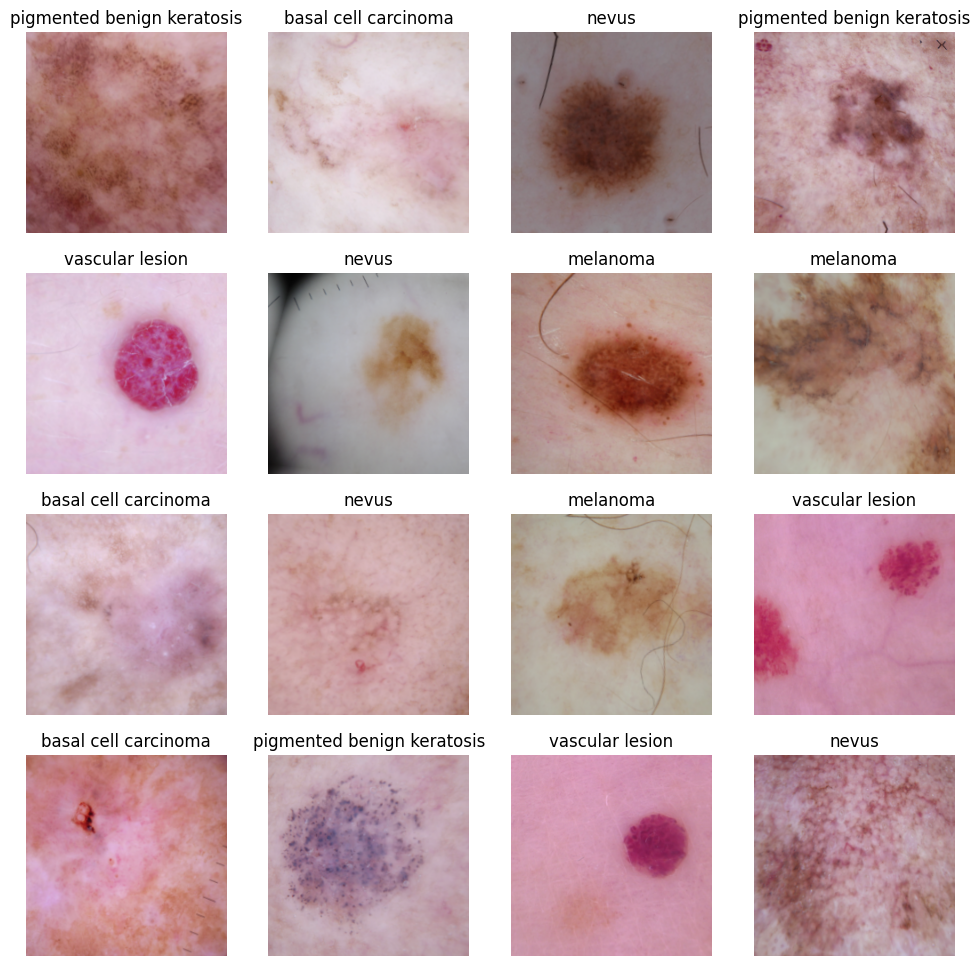

In [ ]:
dls.show_batch(max_n=16)

In [ ]:
learn=vision_learner(dls,resnet18,metrics=accuracy)
learn.fine_tune(25)

epoch,train_loss,valid_loss,accuracy,time
0,2.288284,1.320802,0.586797,01:03


epoch,train_loss,valid_loss,accuracy,time
0,1.496047,1.156595,0.633252,00:36
1,1.337008,1.037618,0.665037,00:38
2,1.175288,0.977034,0.679707,00:38
3,1.080845,0.995413,0.672372,00:36
4,0.934094,0.897579,0.694377,00:41
5,0.812156,1.268189,0.657702,00:37
6,0.698824,1.122878,0.691932,00:37
7,0.598626,1.009332,0.733496,00:39
8,0.509595,1.072414,0.728606,00:37
9,0.474875,0.997509,0.757946,00:37


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-8, 1e-7))

epoch,train_loss,valid_loss,accuracy,time
0,0.075769,1.170072,0.772616,00:36
1,0.075243,1.189071,0.765281,00:38
2,0.082703,1.168264,0.772616,00:36
3,0.074871,1.145794,0.772616,00:35
4,0.065165,1.168979,0.765281,00:40
5,0.073525,1.181448,0.772616,00:37
6,0.070474,1.157579,0.770171,00:38
7,0.075501,1.155899,0.775061,00:40
8,0.071602,1.144739,0.787286,00:37
9,0.070165,1.246267,0.757946,00:37


In [ ]:
preds, targs = learn.tta()
accuracy = (preds.argmax(dim=1) == targs).float().mean()
print(f'TTA Accuracy: {accuracy*100:.4f}%')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

SuggestedLRs(valley=6.918309736647643e-06)

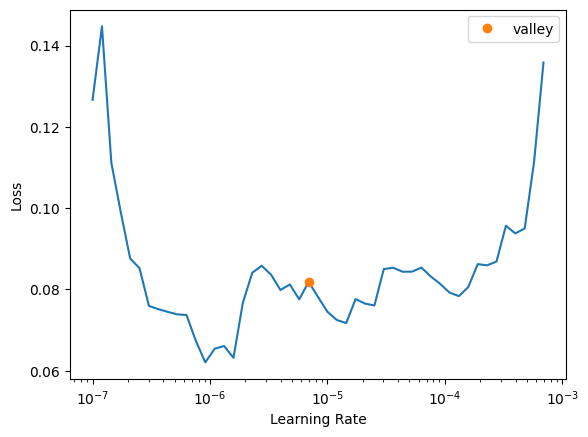

In [ ]:
learn.lr_find()

In [ ]:
learn.show_results()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

preds, targs = learn.get_preds()
preds = preds.numpy()
targs = targs.numpy()


n_classes = preds.shape[1]
precision = dict()
recall = dict()
average_precision = dict()


for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(targs == i, preds[:, i])
    average_precision[i] = average_precision_score(targs == i, preds[:, i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


preds, targs = learn.get_preds()
preds = preds.numpy()
targs = targs.numpy()


n_classes = preds.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targs == i, preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from fastai.vision.all import *
img = PILImage.create("/content/skincancer1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024370.jpg")
pred_class, pred_idx, pred_probs = learn.predict(img)
print(f"Predicted Class: {pred_class}")
print(f"Predicted Probabilities: {pred_probs}")

Predicted Class: vascular lesion
Predicted Probabilities: tensor([1.8377e-05, 1.5915e-05, 6.6247e-08, 6.9719e-06, 1.3074e-04, 6.1039e-08,
        9.9983e-01])
